In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
cd C:\Users\USER\Quant

C:\Users\USER\Quant


 $$ 
 \begin{array}{c}
 y = ln(\frac{K}{S}) \\
 w = {\sigma_{implied}(y,T)}^2  \ T \\ \\
 \bullet \ Central \   difference \\
 \frac{\delta w}{\delta y}[1:-1]  = \frac{w[2:] - w[:-2]}{y[2:]-y[:-2]}
 \\ \\
 \frac{\delta^2 w}{\delta y^2} = \frac{w[2:]-w[1:-2]}{y[2:]-y[:-2]} \times (\frac{w[2:] - w[1:-1]}{y[2:]-y[1:-1]} - \frac{w[1:-1] - w[:-2]}{y[1:-1]-y[:-2]})
 \\
 \\ \\ D = 1-\frac{y}{w}\frac{dw}{dy} + \frac{1}{2}\frac{\delta^2 w}{{\delta y}^2} + \frac{1}{4}( \frac{y^2}{w^2}-\frac{1}{w}-\frac{1}{4} ){(\frac{\delta w}{\delta y})}^2 \\ \\ 
 {\sigma_{local}}^2(T,y) = \frac{dw}{dT} \times \frac{1}{D}
 \\ \\ 
 \end{array}
$$

In [3]:
def calibrate_local_vol(path_option_data, sheet_imvol, Node = 5) :
    imvol = pd.read_excel(path_option_data, sheet_name = sheet_imvol, index_col = 0)
    M = pd.Series(imvol.columns).apply(lambda x : x.split('M')[0]).astype(int)
    T = (np.array(M)/12).reshape(1,-1)
    imvol.columns = T.reshape(-1)
    K = np.array(imvol.index).reshape(-1,1)
    y = np.log(K/100)
    w = np.array(imvol **2 * T)
    w_y = np.zeros(w.shape) * np.nan
    w_y[1:-1] = (w[2:] - w[:-2]) / (y[2:] - y[:-2])
    w_y = np.array(pd.DataFrame(w_y).fillna(method = 'ffill'))
    w_yy = np.zeros(w.shape) * np.nan
    w_yy[1:-1]  =(y[2:]-y[1:-1])/(y[2:] - y[:-2])  * ( (w[2:] - w[1:-1] )/(y[2:] - y[1:-1] ) -  (w[1:-1] - w[:-2] )/(y[1:-1] - y[:-2] ))
    w_yy = np.array(pd.DataFrame(w_yy).fillna(method = 'ffill'))
    w_t1 = (np.array(np.array(pd.DataFrame(w).diff(axis = 1).shift(-1,axis=1))/np.array(pd.DataFrame(T).diff(axis=1).shift(-1,axis=1))))
    w_t2 = (np.array(np.array(pd.DataFrame(w).diff(axis = 1))/np.array(pd.DataFrame(T).diff(axis=1))))
    w_t = np.array((w_t1 + w_t2)/2)
    w_t[:,0]  = w_t1[:,0]
    w_t[:,-1] = w_t2[:,-1]
    D = 1- y/w*w_y + 1/2 * w_yy + 1/4 * ((y/w)**2-1/w-1/4) * (w_y)**2
    local_variance = pd.DataFrame(w_t * 1/D, columns =M , index = K.reshape(-1))
    
    var = pd.concat([local_variance,pd.DataFrame(index = np.arange(50,135,5))],axis = 1).interpolate(method = 'cubic').dropna()
    var = pd.concat([var.T,pd.DataFrame(index = np.arange(3,40,1))],axis=1).interpolate(method = 'cubic').T.dropna(1)
    
    x = np.array(var.iloc[1:].index).reshape(-1,1)
    x_const = np.ones(x.shape)
    X = np.concatenate([x_const,x],axis =1)
    Y = np.array(var.iloc[1:])
    params = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)[-1]

    for i in range(10) : 
        new = var.iloc[-1] + Node * params
        if len(new[new<0])==0 and var.index[-1] + Node < 135:
            new = pd.DataFrame(new.rename(var.index[-1] + Node)).T
            local_var = pd.concat([var,new],axis=0)
        else :
            break
    for i in range(10) :
        new = var.iloc[0] - Node * params
        if len(new[new<0])==0 and var.index[0] - Node > 45:
            new = pd.DataFrame(new.rename(var.index[0] - Node)).T
            var = pd.concat([new,var],axis=0)
        else :
            break 
    return np.sqrt(var)

In [4]:
path_option_data = 'option.xlsx'
sheet_imvol= 'SX5E_vol'
sheet_imvol2 = 'HSI_vol'
HSI_vol = calibrate_local_vol(path_option_data, sheet_imvol2, Node = 5)

In [5]:
HSI_vol

,4,5,6,7,8,9,10,11,12,13,...,31,32,33,34,35,36,37,38,39,40
50,0.488163,0.486270,0.479838,0.470169,0.458587,0.446511,0.435508,0.427302,0.423711,0.425775,...,0.412281,0.409189,0.395233,0.371171,0.338340,0.297809,0.250555,0.197737,0.141486,0.088856
55,0.476207,0.473943,0.467483,0.458068,0.446965,0.435536,0.425283,0.417849,0.414953,0.417547,...,0.404247,0.401202,0.387709,0.364519,0.332969,0.294172,0.249235,0.199621,0.148210,0.103478
60,0.463942,0.461286,0.454792,0.445638,0.435032,0.424277,0.414806,0.408177,0.406005,0.409153,...,0.396049,0.393053,0.380037,0.357744,0.327509,0.290489,0.247908,0.201488,0.154642,0.116276
65,0.442644,0.449614,0.447728,0.439041,0.425371,0.408547,0.390597,0.373907,0.361290,0.355060,...,0.354897,0.352524,0.341950,0.323860,0.299464,0.269908,0.236515,0.201209,0.167415,0.141799
70,0.421552,0.424856,0.421128,0.411842,0.398330,0.381939,0.364162,0.346764,0.331876,0.321444,...,0.319171,0.317316,0.308923,0.294599,0.275414,0.252436,0.226932,0.200683,0.176488,0.158802
75,0.395005,0.388538,0.380135,0.370156,0.358979,0.347016,0.334726,0.322641,0.311370,0.301518,...,0.289015,0.287536,0.281016,0.269973,0.255316,0.237979,0.219071,0.200054,0.182989,0.170719
80,0.355485,0.341553,0.330036,0.320645,0.313005,0.306672,0.301140,0.295859,0.290233,0.283827,...,0.264293,0.263004,0.258011,0.249738,0.238913,0.226301,0.212785,0.199466,0.187750,0.179384
85,0.296338,0.285703,0.277567,0.271634,0.267527,0.264798,0.262956,0.261480,0.259837,0.257602,...,0.244529,0.243215,0.239390,0.233384,0.225738,0.217020,0.207871,0.199042,0.191421,0.186023
90,0.232236,0.231376,0.230230,0.228958,0.227720,0.226684,0.226016,0.225887,0.226462,0.227785,...,0.229103,0.227566,0.224563,0.220342,0.215260,0.209695,0.204059,0.198811,0.194458,0.191544
95,0.192790,0.195717,0.197452,0.198354,0.198764,0.199012,0.199427,0.200334,0.202048,0.204725,...,0.216974,0.215090,0.212652,0.209834,0.206828,0.203842,0.201093,0.198809,0.197227,0.196586


In [12]:
def plotting_local_vol(local_vol, color = 'pink') :
    fun = np.vectorize(lambda Y,X : np.array(local_vol)[Y,X])
    S0=np.array(local_vol.index)
    S1=np.array(local_vol.columns)
    YY,XX = np.meshgrid(S1,S0)
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')
    # Plot a 3D surface
    ax.plot_surface(XX,YY, local_vol ,color = color)
    ax.set_title('Result of Local Volatility')
    ax.set_xlabel('K')
    ax.set_ylabel('T')
    ax.set_zlabel('Volatility')

    plt.show()

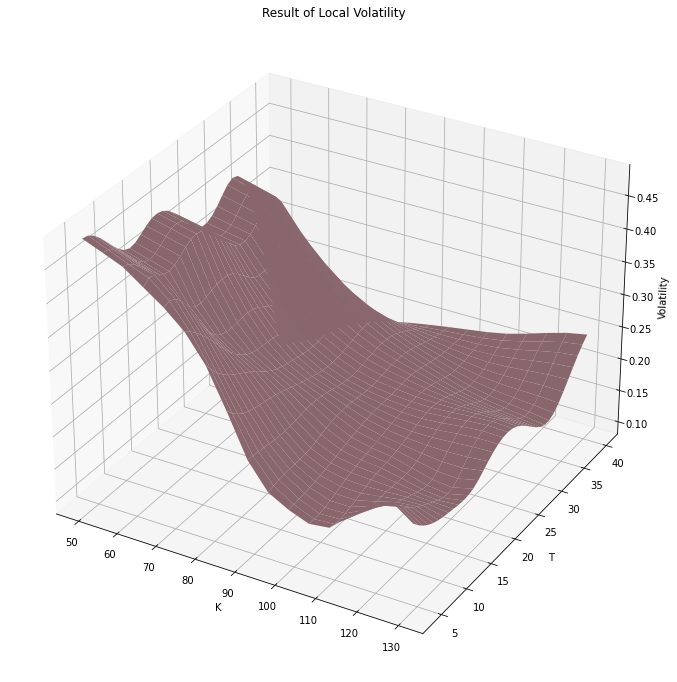

In [13]:
plotting_local_vol(HSI_vol)